In [1]:
%matplotlib inline
import sys
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable
import matplotlib.pyplot as plt
from cartopy import crs, feature

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep


In [2]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/jvalenti/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/jvalenti/MOAD/grid/bathymetry_202108.nc',
'out': '/home/jvalenti/MOAD/results',
'home': '/home/jvalenti/MOAD/analysis-jose/notebooks/parcels',
'anim': '/home/jvalenti/MOAD/animations'}


In [3]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [4]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)


In [5]:
#Definitions
start = datetime(2022, 8, 1) #Start date
length = 1 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 50 # 1000   # number of particles per location
n = 30
dmin = 0 #minimum depth
dd = 150 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [13]:
#Set deploy coordinates following yaml   
clat = [48.24432386965075,48.400439430194574]
clon = [-124.14657923535806,-124.06757317406456]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [14]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile = os.path.join(path['out'], fn)

In [15]:
####BUILD FIELDS FOR SIMULATION######
local = 0

varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol']
filenames,variables=filename_set(start,length,varlist)


#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)


#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Bth)
field_set.add_field(TD)

#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)

####BUILD Particle typeN######
class MPParticle(JITParticle):    
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0) 

In [16]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [17]:
def Advection(particle, fieldset, time): 
    ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t)
    sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt)
    td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth
    particle.fact = (1+ssh/td)
    VVL = (sshn-ssh)*particle.depth/td
    (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
    lon1 = particle.lon + u1*.5*particle.dt
    lat1 = particle.lat + v1*.5*particle.dt
    dep1 = particle.depth + w1*.5*particle.dt/particle.fact
    (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
    lon2 = particle.lon + u2*.5*particle.dt
    lat2 = particle.lat + v2*.5*particle.dt
    dep2 = particle.depth + w2*.5*particle.dt/particle.fact
    (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
    lon3 = particle.lon + u3*particle.dt
    lat3 = particle.lat + v3*particle.dt
    dep3 = particle.depth + w3*particle.dt/particle.fact
    (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
    wa = (w1 + 2*w2 + 2*w3 + w4) /6.
    particle.wa = wa* particle.dt
    particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
    particle_ddepth = particle.wa/particle.fact + VVL
    if particle_ddepth + particle.depth < 0:
        particle_ddepth = - particle_ddepth

def turb_mix(particle,fieldset,time):
    """Vertical mixing"""
    #Vertical mixing
    if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
        Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
    else: 
        Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
    dgrad = Kzdz*particle.dt/particle.fact
    if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
        Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
    else:
        Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

    Rr = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
    dzs = (dgrad + d_random)
    particle.wm = dzs*particle.fact
     

    
def Displacement(particle,fieldset,time):
    ''''Apply movement calculated by other kernels'''

    #Apply turbulent mixing.
    if dzs + particle_ddepth + particle.depth > td: #crossed bottom in dt (Reflect)
        particle_ddepth = 2*td - (dzs + particle_ddepth + 2*particle.depth) #bounce on boundary/ no energy loss
    elif dzs + particle.depth < 0:
        particle_ddepth = -(dzs + 2*particle.depth) #Well mixed boundary layer
    else:
        particle_ddepth += dzs #apply mixing  



def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle_ddepth = 0.0
        particle.state = StatusCode.Success


In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/Test mixing vs advection20220801_1n_20220802_1n.zarr.
100%|██████████| 86400.0/86400.0 [01:32<00:00, 932.26it/s] 


In [19]:
ds = xr.open_zarr(outfile)
advection = np.abs(ds.wa)
mixing = np.abs(ds.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values
#pae = pa.std(dim='trajectory').values/np.sqrt(pa.shape[0]) Very small, not worth plotting

/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'Juan de Fuca August 2022')

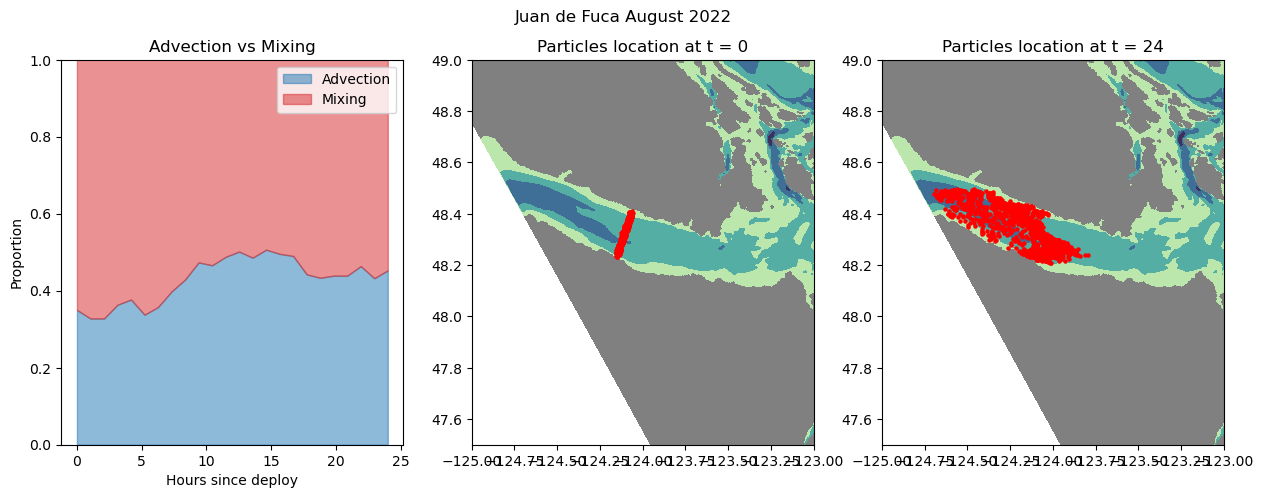

In [20]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0].legend()
axs[0].set_title('Advection vs Mixing')
axs[0].set_ylim([0,1])
axs[0].set_ylabel('Proportion')
axs[0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,500,100))

im=axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1].scatter(ds.lon[:,0],ds.lat[:,0],zorder=3,c='r',s=5)
axs[1].set_ylim([47.5,49])
axs[1].set_xlim([-125,-123])
axs[1].set_title('Particles location at t = 0')

im=axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[2].scatter(ds.lon[:,-1],ds.lat[:,-1],zorder=3,c='r',s=5)
axs[2].set_ylim([47.5,49])
axs[2].set_xlim([-125,-123])
axs[2].set_title(f'Particles location at t = {length*24}')
plt.suptitle('Juan de Fuca August 2022')

In [21]:
#Set deploy coordinates following yaml   
clat = [48.51840443015886,48.537040558621186]
clon = [-123.32656937706203,-123.17742577292043]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [22]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection Haro'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile = os.path.join(path['out'], fn)

In [23]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [24]:
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/Test mixing vs advection Haro20220801_1n_20220802_1n.zarr.
100%|██████████| 86400.0/86400.0 [01:31<00:00, 942.48it/s] 


In [25]:
ds = xr.open_zarr(outfile)
advection = np.abs(ds.wa)
mixing = np.abs(ds.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values

/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'Haro Strait August 2022')

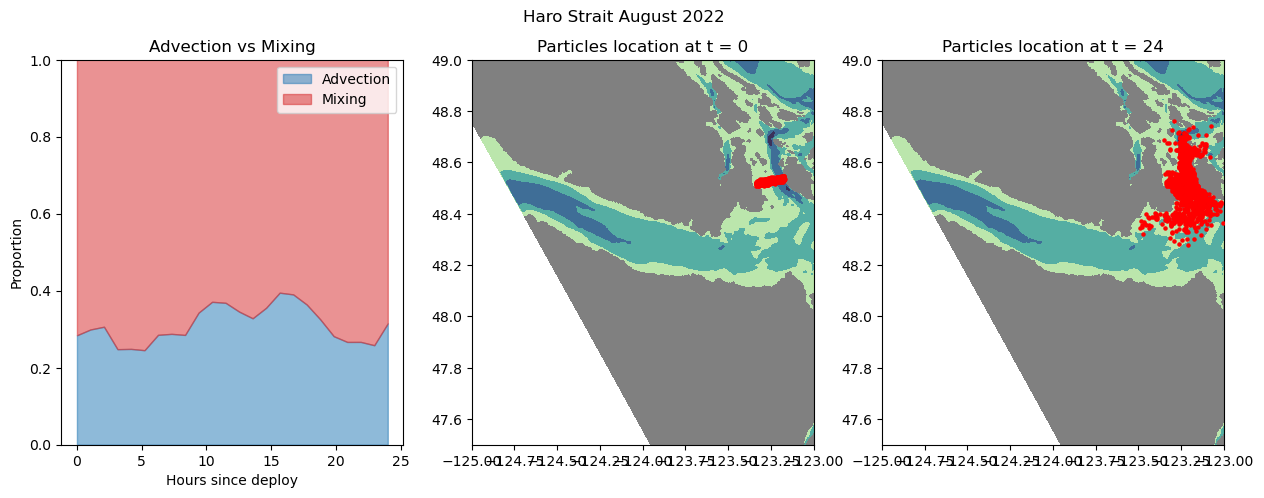

In [26]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0].legend()
axs[0].set_title('Advection vs Mixing')
axs[0].set_ylim([0,1])
axs[0].set_ylabel('Proportion')
axs[0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,500,100))

im=axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1].scatter(ds.lon[:,0],ds.lat[:,0],zorder=3,c='r',s=5)
axs[1].set_ylim([47.5,49])
axs[1].set_xlim([-125,-123])
axs[1].set_title('Particles location at t = 0')

im=axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[2].scatter(ds.lon[:,-1],ds.lat[:,-1],zorder=3,c='r',s=5)
axs[2].set_ylim([47.5,49])
axs[2].set_xlim([-125,-123])
axs[2].set_title(f'Particles location at t = {length*24}')
plt.suptitle('Haro Strait August 2022')

In [27]:
#Definitions
start = datetime(2022, 8, 1) #Start date
length = 1 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 50 # 1000   # number of particles per location
n = 30
dmin = 0 #minimum depth
dd = 400 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [28]:
#Set deploy coordinates following yaml   
clat = [49.27407925138779,49.455498254953405]
clon = [-124.03583927975743,-123.84282669916357]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [29]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection SoG'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile = os.path.join(path['out'], fn)

In [30]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [31]:
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/Test mixing vs advection SoG20220801_1n_20220802_1n.zarr.
100%|██████████| 86400.0/86400.0 [01:36<00:00, 891.27it/s] 


In [32]:
ds = xr.open_zarr(outfile)
advection = np.abs(ds.wa)
mixing = np.abs(ds.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values

Text(0.5, 0.98, 'SoG August 2022')

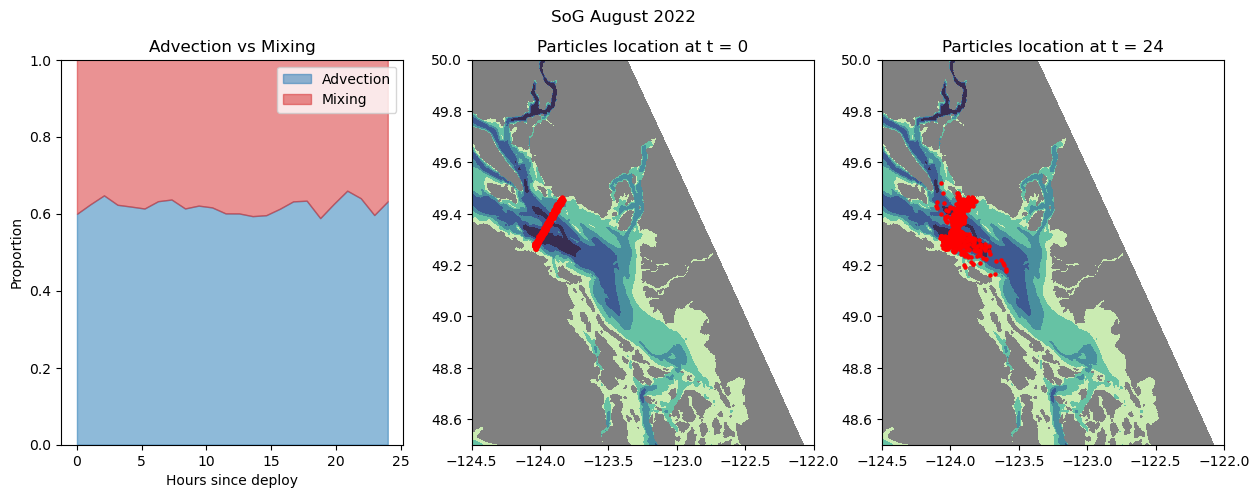

In [33]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0].legend()
axs[0].set_title('Advection vs Mixing')
axs[0].set_ylim([0,1])
axs[0].set_ylabel('Proportion')
axs[0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,550,100))

im=axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1].scatter(ds.lon[:,0],ds.lat[:,0],zorder=3,c='r',s=5)
axs[1].set_ylim([48.5,50])
axs[1].set_xlim([-124.5,-122])
axs[1].set_title('Particles location at t = 0')

im=axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[2].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[2].scatter(ds.lon[:,-1],ds.lat[:,-1],zorder=3,c='r',s=5)
axs[2].set_ylim([48.5,50])
axs[2].set_xlim([-124.5,-122])
axs[2].set_title(f'Particles location at t = {length*24}')
plt.suptitle('SoG August 2022')